Step 1: Generate Simple Shape Images

In [1]:
import numpy as np
import cv2
import os

shapes = ['circle', 'square', 'triangle']
img_size = 28
samples_per_class = 1000
out_dir = 'shape_dataset'

os.makedirs(out_dir, exist_ok=True)

for shape in shapes:
    shape_dir = os.path.join(out_dir, shape)
    os.makedirs(shape_dir, exist_ok=True)

    for i in range(samples_per_class):
        img = np.zeros((img_size, img_size), dtype=np.uint8)
        if shape == 'circle':
            cv2.circle(img, (14, 14), 8, 255, -1)
        elif shape == 'square':
            cv2.rectangle(img, (8, 8), (20, 20), 255, -1)
        elif shape == 'triangle':
            pts = np.array([[14, 5], [5, 22], [23, 22]], np.int32)
            cv2.drawContours(img, [pts], 0, 255, -1)

        cv2.imwrite(os.path.join(shape_dir, f"{i}.png"), img)

Step 2: Train Conditional GAN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
label_map = {'circle': 0, 'square': 1, 'triangle': 2}
num_classes = 3
nz = 100
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 10)
        self.net = nn.Sequential(
            nn.Linear(nz + 10, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        out = self.net(x)
        return out.view(-1, 1, 28, 28)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 10)
        self.net = nn.Sequential(
            nn.Linear(784 + 10, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        img_flat = img.view(img.size(0), -1)
        x = torch.cat([img_flat, label_embedding], dim=1)
        return self.net(x)

Step 3: Training Loop

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(root='shape_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in range(50):
    for real_imgs, labels in dataloader:
        batch_size = real_imgs.size(0)
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, 100).to(device)
        fake_imgs = G(z, labels)

        optimizer_D.zero_grad()
        real_loss = loss_fn(D(real_imgs, labels), valid)
        fake_loss = loss_fn(D(fake_imgs.detach(), labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        gen_imgs = G(z, labels)
        g_loss = loss_fn(D(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch}] D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

torch.save(G.state_dict(), "generator.pth")
torch.save(D.state_dict(), "discriminator.pth")

[Epoch 0] D Loss: 0.7445 | G Loss: 0.7269
[Epoch 1] D Loss: 0.7837 | G Loss: 0.7657
[Epoch 2] D Loss: 0.7666 | G Loss: 0.9024
[Epoch 3] D Loss: 0.7999 | G Loss: 0.9369
[Epoch 4] D Loss: 0.8440 | G Loss: 1.0045
[Epoch 5] D Loss: 0.8594 | G Loss: 0.8477
[Epoch 6] D Loss: 0.8983 | G Loss: 1.1451
[Epoch 7] D Loss: 0.8719 | G Loss: 1.1824
[Epoch 8] D Loss: 0.9224 | G Loss: 1.2816
[Epoch 9] D Loss: 0.8918 | G Loss: 1.3641
[Epoch 10] D Loss: 0.8166 | G Loss: 1.3806
[Epoch 11] D Loss: 0.8186 | G Loss: 0.9550
[Epoch 12] D Loss: 0.8149 | G Loss: 1.4230
[Epoch 13] D Loss: 0.6899 | G Loss: 1.2371
[Epoch 14] D Loss: 0.7287 | G Loss: 1.5094
[Epoch 15] D Loss: 0.7728 | G Loss: 1.4630
[Epoch 16] D Loss: 0.8471 | G Loss: 0.9086
[Epoch 17] D Loss: 0.9268 | G Loss: 1.3397
[Epoch 18] D Loss: 0.9644 | G Loss: 1.2990
[Epoch 19] D Loss: 1.0429 | G Loss: 0.7087
[Epoch 20] D Loss: 1.1044 | G Loss: 1.1182
[Epoch 21] D Loss: 1.2040 | G Loss: 0.6135
[Epoch 22] D Loss: 1.1979 | G Loss: 0.8125
[Epoch 23] D Loss: 1.

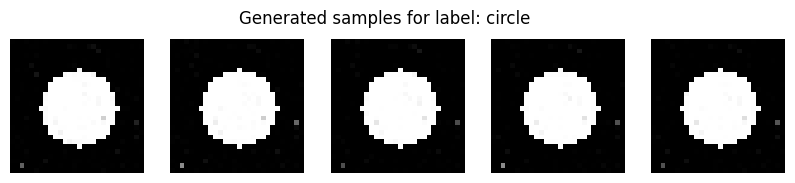

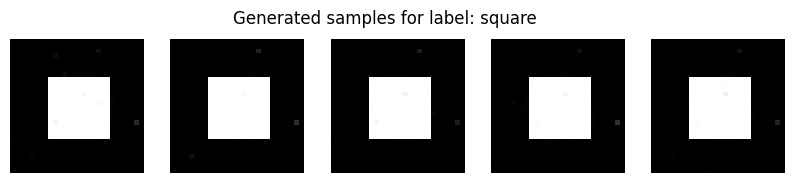

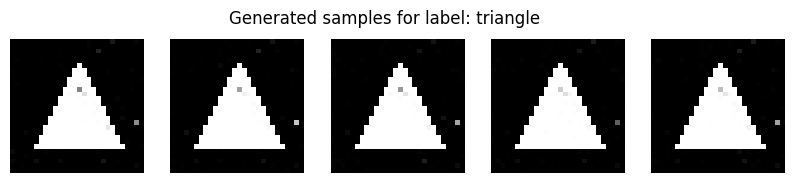

In [9]:
import matplotlib.pyplot as plt

def show_generated_samples(label_name='circle'):
    label = torch.tensor([label_map[label_name]] * 5).to(device)
    noise = torch.randn(5, nz).to(device)
    with torch.no_grad():
        fake_imgs = G(noise, label)
    fake_imgs = fake_imgs.cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(fake_imgs[i][0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Generated samples for label: {label_name}")
    plt.show()

show_generated_samples("circle")
show_generated_samples("square")
show_generated_samples("triangle")


In [11]:
%%writefile requirements.txt
torch>=2.0.0
torchvision>=0.16.0
numpy
opencv-python
matplotlib


Writing requirements.txt


In [10]:
%%writefile README.md
Task 2: Conditional GAN for Shape Generation

This project trains a CGAN model to generate basic shape images based on text labels like "circle", "square", or "triangle".

1) How to Run
1. Install dependencies:
pip install -r requirements.txt

markdown
Copy
Edit
2. Generate dataset:
python generate_shapes.py

markdown
Copy
Edit
3. Open `cgan_shapes.ipynb` and train the model.

2) Outputs
- Trained CGAN model
- Synthetic images of shapes

Writing README.md
